In [389]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [390]:
def rot_matrix(radians):
    return np.array([[np.cos(radians), -np.sin(radians)], 
                     [np.sin(radians), np.cos(radians)]])

In [391]:
def stroke(x0, y0, radians, length, width, window_size=(16, 16)):
    # Direct reconstrucion from Alistair's code
    
    #
    x = np.arange(window_size[0]) - x0
    y = np.arange(window_size[0]) - y0
    
    #
    ux = x * np.cos(radians)
    uy = y * np.sin(radians)
    
    #
    vx = -x * np.sin(radians)
    vy = y * np.cos(radians)
    
    # 
    u = np.repeat(np.reshape(ux, (1, window_size[0])), window_size[0], axis=0) + \
        np.repeat(np.reshape(uy, (window_size[0], 1)), window_size[0], axis=1)
    v = np.repeat(np.reshape(vx, (1, window_size[0])), window_size[0], axis=0) + \
        np.repeat(np.reshape(vy, (window_size[0], 1)), window_size[0], axis=1)

    
    region = (0 < v) & (v < length)
    
    return np.exp(- (u ** 2) / width) * region


def stroke2(x0, y0, radians, length, width, window_size=16):
    # My version usings all matrix operations
    
    # 2x2
    rot = rot_matrix(radians)
    
    # (x - x0)
    # (y - y0)
    # 2xwindow_size
    xy = np.repeat(np.arange(window_size)[np.newaxis, :], 2, axis=0) - [[x0-1], [y0-1]]
    
    # (ux, uy)
    # (vx, vy)
    # 2x2xwindow_size
    uv_xy = np.apply_along_axis(lambda x: np.multiply(rot, x), axis=0, arr=xy)
    
    # (ux + uyT)
    # (vx + vyT)
    # 2xwindow_sizexwindow_size
    u, v = (uv_xy[:, 0, np.newaxis, :] + uv_xy[:, 1, :, np.newaxis])
    
    
    region = (0 < v) & (v < length)
    
    return np.exp(- (u / width) ** 2) * region

In [392]:
def many_strokes(list_params, window_size=16, kind="max"):
    # params.shape: (n, n_strokes, 5)
    
    stroke_lam = lambda x: stroke2(*x, window_size=window_size)
    strokes = np.apply_along_axis(stroke_lam, -1, list_params)

    # strokes.shape: (n, n_strokes, window_size, window_size)
    
    kinds = {
        "sum": lambda strokes: strokes.sum(axis=1),
        "clip": lambda strokes: np.clip(strokes.sum(axis=1), 0, 1),
        "max": lambda strokes: strokes.max(axis=1),
    }
    
    return kinds[kind](strokes)

---

In [426]:
params = [
    [5, 5, np.pi/2, 10, 2],
    [13, 5, -np.pi/8, 10, 2],
]

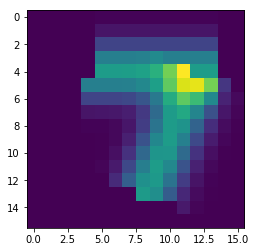

In [428]:
plt.imshow(many_strokes(params, 16, kind="sum"))

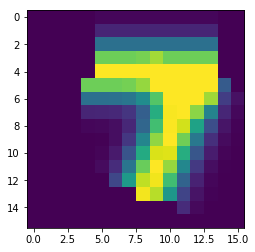

In [429]:
plt.imshow(many_strokes(params, 16, kind="clip"))

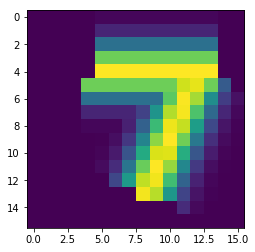

In [430]:
plt.imshow(many_strokes(params, 16, kind="max"))

---

# Genetic Algorithm

* Parameter space
* Generate Population
* Evaluate individual
* Select best individual
* Breed children

In [393]:
param_space = np.array([(0, 16), (0, 16), (0, np.pi), (5, 22), (1, 3)])

In [394]:
def gen_population(param_space, n, depth):
    # Randomly samples from the given parameter space
    # Uniform over each interval
    _min = param_space[:,0]
    _max = param_space[:,1]
    
    # (b - a) * rand + a
    
    scale = lambda x: (_max - _min) * x + _min
    return np.apply_along_axis(scale, 2, np.random.random_sample((n, depth, len(param_space))))

def gen_individual(param_space, depth):
    return gen_population(param_space, 1, depth)

In [395]:
# Paired
def breed_avg(a, b):
    return np.mean([a, b], axis=0)

def breed_pick_one(a, b):
    # Choice matrix
    c = np.random.randint(2, size=a.shape)
    return a * c + b * (1 - c)

def breed_uniform(a, b):
    # Weight matrix
    c = np.random.random(a.shape)
    return a * c + b * (1 - c)

# Single
def breed_rand(a, param_space, breed_func=breed_uniform):
    # Choice matrix
    c = np.random.randint(2, size=a.shape)
    new = gen_population(param_space, len(a), a.shape[1])
    
    return breed_func(a, new)

def breed_perturb(a, param_space, perturb_factor=0.1):    
    _min = param_space[:,0]
    _max = param_space[:,1]
    
    changes = (np.random.random(a.shape) - 0.5) * perturb_factor
    a_norm = (a - _min) / (_max - _min)
    
    out = np.clip(a_norm + changes, 0, 1) * (_max - _min) + _min
    return out
    
    
    

def breed(candidates, n, breed_func=breed_pick_one, param_space=None, breed_func_kwargs={}):
    # candidates.shape: (n, depth, n_params)
    
    # Pair odds & evens
#     cand_pairs = [candidates[::2], candidates[1::2]]
    
    
    # Random pairs with replacement
    cand_pairs = candidates[np.random.randint(len(candidates), size=(2, n)),]
    
    if breed_func in (breed_rand, breed_perturb):
        assert param_space is not None
        children = breed_func(cand_pairs[0], param_space, **breed_func_kwargs)
    else:
        children = breed_func(cand_pairs[0], cand_pairs[1], **breed_func_kwargs)
    
    return children

In [396]:
def gen_next_pop(param_space, n, depth, breed_candidates, breed_proportion, parent_proportion, 
                 breed_func=breed_pick_one, breed_func_kwargs={}):
    n_breed = int(n * breed_proportion)
    n_parent = min(int (n * parent_proportion), len(breed_candidates))
    n_gen = n - n_breed - n_parent
    
    # Breed
    ch1 = breed_candidates[:n_parent]
    ch2 = breed(breed_candidates, n_breed, breed_func=breed_func, param_space=param_space, breed_func_kwargs=breed_func_kwargs)
    ch3 = gen_population(param_space, n_gen, depth)
    
    return np.concatenate((ch1, ch2, ch3))

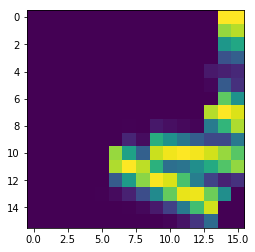

In [538]:
pop = gen_population(param_space, 5, 4)
pop_img = many_strokes(pop)
plt.imshow(pop_img[0])

---

# Load digits

In [515]:
digits = pd.read_csv("./data/digits/Zl3d.dat", sep=" ", header=None).drop(columns=[256]).values.reshape((-1, 16, 16)) / 255

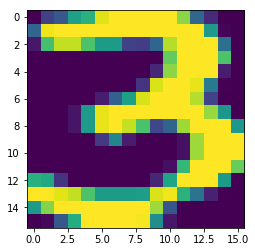

In [516]:
target = digits[0]
plt.imshow(target)

In [217]:
def euclidean2(a, b, axis=None):
    return np.sum((a - b) ** 2, axis=axis)

---

In [578]:
pop_size = 100
n_strokes = 5
n_candidates = 50

for i in range(100):
    if i == 0:
        pop = gen_population(param_space, pop_size, n_strokes)
    else:
        pop = gen_next_pop(param_space, pop_size, n_strokes, parents, 0.1, 0.05, 
                           breed_func=breed_rand, breed_func_kwargs={"perturb_factor": 0.95**i})
        
    pop_img = many_strokes(pop)
    pop_err = euclidean2(pop_img, target, axis=(1,2))
    pop_ord = pop_err.argsort()
    parents = pop[pop_ord[:n_candidates]]
    
    print(i, ":", pop_err[pop_ord[0]])

0 : 55.550059563844854
1 : 55.550059563844854
2 : 51.298960701389184
3 : 51.298960701389184
4 : 51.298960701389184
5 : 51.298960701389184
6 : 49.757963050314075
7 : 49.757963050314075
8 : 40.995298989372
9 : 40.995298989372
10 : 40.995298989372
11 : 40.995298989372
12 : 40.04684037860493
13 : 40.04684037860493
14 : 40.04684037860493
15 : 40.04684037860493
16 : 40.04684037860493
17 : 40.04684037860493
18 : 40.04684037860493
19 : 40.04684037860493
20 : 40.04684037860493
21 : 40.04684037860493
22 : 40.04684037860493
23 : 40.04684037860493
24 : 40.04684037860493
25 : 40.04684037860493
26 : 40.04684037860493
27 : 40.04684037860493
28 : 40.04684037860493
29 : 40.04684037860493
30 : 40.04684037860493
31 : 40.04684037860493
32 : 40.04684037860493
33 : 40.04684037860493
34 : 40.04684037860493
35 : 40.04684037860493
36 : 40.04684037860493
37 : 40.04684037860493
38 : 40.04684037860493
39 : 40.04684037860493
40 : 40.04684037860493
41 : 40.04684037860493
42 : 40.04684037860493
43 : 40.0468403786049

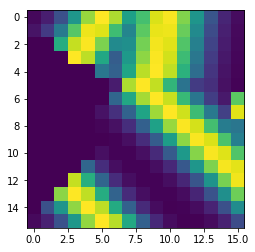

In [581]:
plt.imshow(pop_img[pop_ord[2]])

In [577]:
euclidean2(pop_img[pop_ord[0]], pop_img[pop_ord[1]])

0.39472395354164064

In [564]:
breed_perturb(pop[pop_ord[0]], param_space)

array([[1.29582862e+00, 2.85400709e+00, 1.62629475e+00, 1.35404392e+01,
        1.31105092e+00],
       [7.39524011e+00, 1.03128941e+01, 2.60947360e+00, 1.59364777e+01,
        1.29130697e+00],
       [7.13684264e-01, 1.39531525e+01, 1.01173047e+00, 8.89090586e+00,
        2.44711550e+00],
       [1.39740481e+01, 1.28179137e+01, 2.17797557e+00, 1.71815011e+01,
        2.05111766e+00],
       [1.19090288e+01, 2.48014481e+00, 8.12387777e-03, 1.35076269e+01,
        3.00000000e+00]])

---

# Changing how parameters are defined

In [528]:
class Param:
    value = None
    
    # reduces Param objects to floats
    get_val = np.vectorize(lambda x: x.value)
    
    def __init__(self, _min, _max, val=None):
        self.min = _min
        self.max = _max
        
        if val:
            self.value = val
            self.clip()
        
    
    def perturb(self, proportion):
        change = (self.max - self.min) * proportion * (np.random.random() * 2 - 1)
        self += change
    
    def __str__(self):
        out = "min: {: .5f}, max: {: .5f}".format(self.min, self.max)
        
        if self.value:
            out += ", val: {: .5f}".format(self.value)
        
        return out
    
    def __repr__(self):
        return "{:.5f}".format(self.value)
    
    def __neg__(self):
        return - self.value
    
    def __add__(self, other):
        # Adding two parameters
        if issubclass(self.__class__, Param) and issubclass(other.__class__, Param):
            return self.value + other.value
        
        # Adding this and a number
        return self.__class__(self.min, self.max, self.value + other)
    
    def __sub__(self, other):
        return self.__add__(-other)
    
    def __mul__(self, other):
        # Two parameters
        if issubclass(self.__class__, Param) and issubclass(other.__class__, Param):
            return self.value * other.value
        
        # This and a number
        return self.__class__(self.min, self.max, self.value * other)
        
    def __iadd__(self, other):
        # Two parameters
        if issubclass(self.__class__, Param) and issubclass(other.__class__, Param):
            other = other.value
        
        self.value += other
        self.clip()
        return self
    
    def __isub__(self, amount):
        return self.__iadd__(-amount)
    
    
    def generate(self, n=1):
        vals = (self.max - self.min) * np.random.random((n,)) + self.min
        return np.array([self.__class__(self.min, self.max, val) for val in vals])
    
    
        
class ParamLinear(Param):
    def clip(self):
        self.value = np.clip(self.value, self.min, self.max)
    
class ParamCircular(Param):
    def clip(self):
        self.value = ((self.value - self.min) % (self.max - self.min)) + self.min
        
        
        
class ParamSpace:
    def __init__(self, params):
        self.params = np.array(params)
    
    def __str__(self):
        return "\n".join(map(str, self.params))
    
    def __repr__(self):
        return self.__str__()
    
    def generate(self, shape=(1,)):
        n = np.prod(shape)
        return np.array([p.generate(n) for p in self.params]).T.reshape(shape + (-1,))
    
    
    @classmethod
    def from_list(cls, l):
        # l: [(min, max, type), ...]
        
        types = {"C": ParamCircular, "L": ParamLinear, }
        
        params = [types[_type](_min, _max) for (_min, _max, _type) in l]
        return cls(params)
        

In [440]:
param_space2 = ParamSpace.from_list([(0, 16, "L"), (0, 16, "L"), (0, np.pi, "C"), (2, 22, "L"), (1, 5, "L")])
param_space2

min:  0.00000, max:  16.00000
min:  0.00000, max:  16.00000
min:  0.00000, max:  3.14159
min:  2.00000, max:  22.00000
min:  1.00000, max:  5.00000

In [529]:
x = param_space2.generate((3, 4))

[[[14.07434 13.66963 1.98408 13.82325 1.46948]
  [7.48112 11.83167 1.61576 10.41455 2.63185]
  [0.09296 0.58150 1.87757 4.82323 4.23638]
  [3.50626 1.45070 1.17750 12.76573 3.78071]]

 [[10.16456 1.79825 1.36576 17.44246 3.30036]
  [3.93186 2.29843 2.65367 8.25311 2.53081]
  [8.09981 11.63000 2.40541 21.62842 4.13680]
  [10.05418 15.56847 0.17665 13.70195 1.94433]]

 [[15.09187 3.51356 2.35204 8.35053 4.11207]
  [6.81513 1.38748 1.26180 3.11673 4.63294]
  [3.45807 7.76896 2.09344 20.40355 1.36514]
  [3.43924 8.19575 1.67632 21.56894 3.15931]]]


7372800